In [1]:
import os
import sys
import pickle
import gc
import graphviz

import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation
import scipy.stats as sps
import seaborn as sns

from IPython.display import HTML

# sys.path.append('./pyfac')

Visualize message passing for factor-graph with algorithm Sum-Product.

The directions of messages should be visualized in the resulting plots.

Graph and model parameters must be sampled randomly during each run of notebook.

Visualization format - plots step by step via interactive plots or animation.

In [2]:
from builtins import range
from functools import reduce
import numpy as np

""" Factor Graph classes forming structure for PGMs
    Basic structure is port of MATLAB code by J. Pacheco
    Central difference: nbrs stored as references, not ids
        (makes message propagation easier)

    Note to self: use %pdb and %load_ext autoreload followed by %autoreload 2
"""

class Node(object):
    """ Superclass for graph nodes
    """
    epsilon = 10**(-4)

    def __init__(self, nid):
        self.enabled = True
        self.nid = nid
        self.nbrs = []
        self.incoming = []
        self.outgoing = []
        self.oldoutgoing = []

    def reset(self):
        self.enabled = True

    def disable(self):
        self.enabled = False

    def enable(self):
        self.enabled = True
        for n in self.nbrs:
            # don't call enable() as it will recursively enable entire graph
            n.enabled = True

    def nextStep(self):
        """ Used to have this line in prepMessages
            but it didn't work?
        """
        self.oldoutgoing = self.outgoing[:]

    def normalizeMessages(self):
        """ Normalize to sum to 1
        """
        self.outgoing = [x / np.sum(x) for x in self.outgoing]

    def receiveMessage(self, f, m):
        """ Places new message into correct location in new message list
        """
        if self.enabled:
            i = self.nbrs.index(f)
            self.incoming[i] = m

    def sendMessages(self):
        """ Sends all outgoing messages
        """
        for i in range(0, len(self.outgoing)):
            self.nbrs[i].receiveMessage(self, self.outgoing[i])

    def checkConvergence(self):
        """ Check if any messages have changed
        """
        if self.enabled:
            for i in range(0, len(self.outgoing)):
                # check messages have same shape
                self.oldoutgoing[i].shape = self.outgoing[i].shape
                delta = np.absolute(self.outgoing[i] - self.oldoutgoing[i])
                if (delta > Node.epsilon).any(): # if there has been change
                    return False
            return True
        else:
            # Always return True if disabled to avoid interrupting check
            return True

class VarNode(Node):
    """ Variable node in factor graph
    """
    def __init__(self, name, dim, nid):
        super(VarNode, self).__init__(nid)
        self.name = name
        self.dim = dim
        self.observed = -1 # only >= 0 if variable is observed

    def reset(self):
        super(VarNode, self).reset()
        size = range(0, len(self.incoming))
        self.incoming = [np.ones((self.dim,1)) for i in size]
        self.outgoing = [np.ones((self.dim,1)) for i in size]
        self.oldoutgoing = [np.ones((self.dim,1)) for i in size]
        self.observed = -1

    def condition(self, observation):
        """ Condition on observing certain value
        """
        self.enable()
        self.observed = observation
        # set messages (won't change)
        for i in range(0, len(self.outgoing)):
            self.outgoing[i] = np.zeros((self.dim,1))
            self.outgoing[i][self.observed] = 1.
        self.nextStep() # copy into oldoutgoing

    def prepMessages(self):
        """ Multiplies together incoming messages to make new outgoing
        """

        # compute new messages if no observation has been made
        if self.enabled and self.observed < 0 and len(self.nbrs) > 1:
            # switch reference for old messages
            self.nextStep()
            for i in range(0, len(self.incoming)):
                # multiply together all excluding message at current index
                curr = self.incoming[:]
                del curr[i]
                self.outgoing[i] = reduce(np.multiply, curr)

            # normalize once finished with all messages
            self.normalizeMessages()

class FacNode(Node):
    """ Factor node in factor graph
    """
    def __init__(self, P, nid, *args):
        super(FacNode, self).__init__(nid)
        self.P = P
        self.nbrs = list(args) # list storing refs to variable nodes

        # num of edges
        numNbrs = len(self.nbrs)
        numDependencies = self.P.squeeze().ndim

        # init messages
        for i in range(0,numNbrs):
            v = self.nbrs[i]
            vdim = v.dim

            # init for factor
            self.incoming.append(np.ones((vdim,1)))
            self.outgoing.append(np.ones((vdim,1)))
            self.oldoutgoing.append(np.ones((vdim,1)))

            # init for variable
            v.nbrs.append(self)
            v.incoming.append(np.ones((vdim,1)))
            v.outgoing.append(np.ones((vdim,1)))
            v.oldoutgoing.append(np.ones((vdim,1)))

        # error check
        assert (numNbrs == numDependencies), "Factor dimensions does not match size of domain."

    def reset(self):
        super(FacNode, self).reset()
        for i in range(0, len(self.incoming)):
            self.incoming[i] = np.ones((self.nbrs[i].dim,1))
            self.outgoing[i] = np.ones((self.nbrs[i].dim,1))
            self.oldoutgoing[i] = np.ones((self.nbrs[i].dim,1))

    def prepMessages(self):
        """ Multiplies incoming messages w/ P to make new outgoing
        """
        if self.enabled:
            # switch references for old messages
            self.nextStep()

            mnum = len(self.incoming)

            # do tiling in advance
            # roll axes to match shape of newMessage after
            for i in range(0,mnum):
                # find tiling size
                nextShape = list(self.P.shape)
                del nextShape[i]
                nextShape.insert(0, 1)
                # need to expand incoming message to correct num of dims to tile properly
                prepShape = [1 for x in nextShape]
                prepShape[0] = self.incoming[i].shape[0]
                self.incoming[i].shape = prepShape
                # tile and roll
                self.incoming[i] = np.tile(self.incoming[i], nextShape)
                self.incoming[i] = np.rollaxis(self.incoming[i], 0, i+1)

            # loop over subsets
            for i in range(0, mnum):
                curr = self.incoming[:]
                del curr[i]
                newMessage = reduce(np.multiply, curr, self.P)

                # sum over all vars except i!
                # roll axis i to front then sum over all other axes
                newMessage = np.rollaxis(newMessage, i, 0)
                newMessage = np.sum(newMessage, tuple(range(1,mnum)))
                newMessage.shape = (newMessage.shape[0],1)

                #store new message
                self.outgoing[i] = newMessage

            # normalize once finished with all messages
            self.normalizeMessages()

In [3]:
# Graph class
from __future__ import print_function
from builtins import range
from future.utils import iteritems
import numpy as np
import pdb

""" Factor Graph classes forming structure for PGMs
    Basic structure is port of MATLAB code by J. Pacheco
    Central difference: nbrs stored as references, not ids
        (makes message propagation easier)
"""

class Graph:
    """
    Putting everything together
    """

    def __init__(self):
        self.var = {}
        self.fac = []
        self.dims = []
        self.converged = False

    def addVarNode(self, name, dim):
        newId = len(self.var)
        newVar = VarNode(name, dim, newId)
        self.var[name] = newVar
        self.dims.append(dim)

        return newVar

    def addFacNode(self, P, *args):
        newId = len(self.fac)
        newFac = FacNode(P, newId, *args)
        self.fac.append(newFac)

        return newFac

    def disableAll(self):
        """ Disable all nodes in graph
            Useful for switching on small subnetworks
            of bayesian nets
        """
        for k, v in iteritems(self.var):
            v.disable()
        for f in self.fac:
            f.disable()

    def reset(self):
        """ Reset messages to original state
        """
        for k, v in iteritems(self.var):
            v.reset()
        for f in self.fac:
            f.reset()
        self.converged = False
    
    def plot(self, marginals=None):
        t = graphviz.Graph('Graph', format='png')
        reversed_var = {v: k for k, v in self.var.items()}
        
        if marginals is None:
            marginals = self.calc_prob()
        image_names = []

        t.attr('node', shape='circle', fixedsize='true', width='0.9')
        for nm, node in self.var.items():
            plt.pie(
                marginals[nm].reshape(-1),
                autopct='%.1f%%',
                radius=2
            )
            
            img_nm = f'{nm}-distribution.svg'
            image_names.append(img_nm)
            
            plt.savefig(img_nm)
            plt.close()
            t.node(f'{nm}-{node.nid:d}', image=img_nm)
            
        t.attr('node', shape='box')
        for factor in self.fac:
            t.node(f'factor-{factor.nid:d}')
            
            for node in factor.nbrs:
                node_nm = reversed_var[node]
                t.edge(f'factor-{factor.nid:d}', f'{node_nm}-{node.nid:d}')
            
        t.attr(overlap='false')
        t.attr(fontsize='12')

        filepath = t.view(cleanup=False, quiet=True)
        
        for img in image_names:
            os.remove(img)
        
        return filepath

    def sumProduct(self, maxsteps=500, return_probs=False):
        """ This is the algorithm!
            Each timestep:
            take incoming messages and multiply together to produce outgoing for all nodes
            then push outgoing to neighbors' incoming
            check outgoing v. previous outgoing to check for convergence
        """
        # loop to convergence
        timestep = 0
        probs_history = []
        while timestep < maxsteps and not self.converged: # run for maxsteps cycles
            timestep = timestep + 1

            for f in self.fac:
                # start with factor-to-variable
                # can send immediately since not sending to any other factors
                f.prepMessages()
                f.sendMessages()

            for k, v in iteritems(self.var):
                # variable-to-factor
                v.prepMessages()
                v.sendMessages()

            # check for convergence
            t = True
            for k, v in iteritems(self.var):
                t = t and v.checkConvergence()
                if not t:
                    break
            if t:
                for f in self.fac:
                    t = t and f.checkConvergence()
                    if not t:
                        break

            if t: # we have convergence!
                self.converged = True
            
            probs_history.append(self.calc_prob())
            
        # if run for 500 steps and still no convergence:impor
        if not self.converged:
            print("No convergence!")
        
        return probs_history if return_probs else None
    
    def calc_prob(self):
        marginals = {}
        # for each var
        for k, v in iteritems(self.var):
            if v.enabled: # only include enabled variables
                # multiply together messages
                vmarg = 1
                for i in range(0, len(v.incoming)):
                    vmarg = vmarg * v.incoming[i]

                # normalize
                n = np.sum(vmarg)
                vmarg = vmarg / n

                marginals[k] = vmarg
        
        return marginals

    def marginals(self, maxsteps=500, return_probs=False):
        """ Return dictionary of all marginal distributions
            indexed by corresponding variable name
        """
        # Message pass
        result = self.sumProduct(maxsteps, return_probs)
        
        if return_probs:
            return result, self.calc_prob()
        else:
            return self.calc_prob()

In [4]:
G = Graph()

# add variable nodes
a = G.addVarNode('a', 3)
b = G.addVarNode('b', 4)
c = G.addVarNode('c', 5)

# add factors
# unary factor
Pb = np.random.rand(4, 1, 1) #np.array([[0.3],[0.7]])
Pb /= Pb.sum()
G.addFacNode(Pb, b)

# connecting factor
Pac = np.random.rand(3, 5, 1) # np.array([[0.2, 0.8], [0.4, 0.6], [0.1, 0.9]])
Pac /= Pac.sum(axis=-1, keepdims=True)
G.addFacNode(Pac, a, c)

Pabc = np.random.rand(3, 4, 5)
Pabc /= Pabc.sum(axis=-1, keepdims=True)
G.addFacNode(Pabc, a, b, c)

# factors can connect an arbitrary number of variables

# run sum-product and get marginals for variables
prob_hist, marg = G.marginals(return_probs=True)
# distA = marg['a']
# distB = marg['b']
# G.plot()

MovieWriter imagemagick unavailable; using Pillow instead.
gio: file:///home/eduard/dep-tasks/bmm/Graph.gv.png: Ошибка при получении информации о файле «/home/eduard/dep-tasks/bmm/Graph.gv.png»: Нет такого файла или каталога
gio: file:///home/eduard/dep-tasks/bmm/Graph.gv.png: Ошибка при получении информации о файле «/home/eduard/dep-tasks/bmm/Graph.gv.png»: Нет такого файла или каталога
gio: file:///home/eduard/dep-tasks/bmm/Graph.gv.png: Ошибка при получении информации о файле «/home/eduard/dep-tasks/bmm/Graph.gv.png»: Нет такого файла или каталога
gio: file:///home/eduard/dep-tasks/bmm/Graph.gv.png: Ошибка при получении информации о файле «/home/eduard/dep-tasks/bmm/Graph.gv.png»: Нет такого файла или каталога


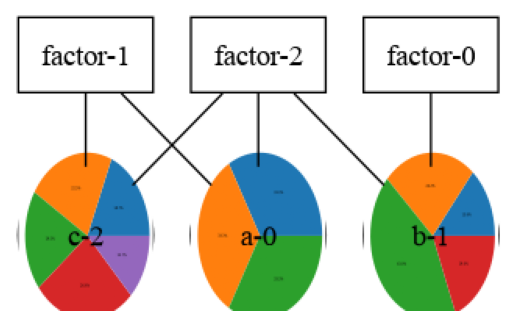

In [5]:
def drawframe(n, prob_history=prob_hist, graph=G):
    img_path = graph.plot(marginals=prob_history[n])
    new_img_path = img_path[:img_path.find('.png')] + f'_{n}' + '.png'
    os.rename(img_path, new_img_path)
    
    img = plt.imread(new_img_path)
    plt.axis('off')
    plt.imshow(img)
    
#     os.remove(new_img_path)


plt.subplots_adjust(top=1, bottom=0, left=0, right=1)
anim = animation.FuncAnimation(plt.gcf(), drawframe, frames=len(prob_hist), interval=(2000.0/len(prob_hist)))
anim.save(
    'output.gif',
    writer='imagemagick'
)

In [30]:
import imageio.v2 as imageio



list_of_im_paths = [f'Graph.gv_{i}.png' for i in range(3)]
ims = [imageio.imread(f) for f in list_of_im_paths]
imageio.mimwrite('example.gif', ims)